# Quadruped Jump
My idea on a trajectory optimization method for jumps and maybe even more versatile movements. The future goal is to find a reliable method for trajectory generation of dance movements similar to the video from Boston Dynamics.

The core idea is taken from A. Winklers [PhD-thesis](https://storage.googleapis.com/concise-hue-230505.appspot.com/pdfs/18-phd-winkler.pdf), however there are two major differences in my method:
1. The optimization is of linear nature as the COM movement is predefined. Therefore, we can hopefully use a QP solver, which I'm more familiar with right now.
2. Time intervals are predefined as well. The goal is to teach the robot some kind of choreography, that's why we can and have to implement individual constraints for each motion.

In [112]:
# imports
import numpy as np
np.set_printoptions(precision=5, suppress=True)
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.interpolate import CubicHermiteSpline as hspline

#### Dynamic Model
The underlying dynamic model is the Single Rigid Body Dynamics model described in the notebook `State_Model`.

With $\textbf{f}$ beeing the force vector that contains all leg forces

$$
\textbf{f} = (\textbf{f}_0^T, \,\textbf{f}_1^T, \,\textbf{f}_2^T, \,\textbf{f}_3^T)^T
$$

the whole state model is:

$$
\underbrace{
    \left( \begin{array}{ccc}
    \textbf{I}_{3\times3} & ... & \textbf{I}_{3\times3} \\ 
    [\textbf{p}_0 - \textbf{p}_{\mathrm{c}}]_{\times} & ... & [\textbf{p}_3 - \textbf{p}_{\mathrm{c}}]_{\times} \\ 
    \end{array}\right)
}_\textbf{A}
\textbf{ f}
=
\underbrace{
    \left( \begin{array}{c}
    m\,(\ddot{\textbf{p}}_C + \textbf{g}) \\
    \textbf{I}_\mathrm{G}\,\dot{\omega}_\mathrm{b} \\ 
    \end{array}\right)
}_\textbf{b}
$$

with $\textbf{I}_{3\times3}$ being a 3x3 identity matrix

To rewrite this model into the State-Space-representation $\dot{x} = A(t)x(t) + B(t)u(t)$, we define the state vector as:


$$
\textbf{x}
=
\left( \begin{array}{c}
    \textbf{p}\\
    \boldsymbol{\omega}\\
    \dot{\textbf{p}}\\
    \dot{\boldsymbol{\omega}}\\
    \end{array}\right)
$$





The State-space-representation can be now written as:

$$
\dot{
    \left( \begin{array}{c}
    \textbf{p}_c\\
    \boldsymbol{\omega}_c\\
    \dot{\textbf{p}}_c\\
    \dot{\boldsymbol{\omega}}_c\\
    \end{array}\right)
}
=
\underbrace{
\left( \begin{array}{cccc}
    \boldsymbol{0}_{3\times3} & \boldsymbol{0}_{3\times3} & \boldsymbol{I}_{3\times3} & \boldsymbol{0}_{3\times3}\\
    \boldsymbol{0}_{3\times3} & \boldsymbol{0}_{3\times3} & \boldsymbol{0}_{3\times3} & \boldsymbol{I}_{3\times3}\\
    \boldsymbol{0}_{3\times3} & \boldsymbol{0}_{3\times3} & \boldsymbol{0}_{3\times3} & \boldsymbol{0}_{3\times3}\\
    \boldsymbol{0}_{3\times3} & \boldsymbol{0}_{3\times3} & \boldsymbol{0}_{3\times3} & \boldsymbol{0}_{3\times3}\\
    \end{array}\right)
}_\textbf{A}
\,
\left( \begin{array}{c}
    \textbf{p}_c\\
    \boldsymbol{\omega}_c\\
    \dot{\textbf{p}}_c\\
    \dot{\boldsymbol{\omega}}_c\\
    \end{array}\right)
+
\underbrace{
\left( \begin{array}{cccc}
    \boldsymbol{0}_{3\times3} & \boldsymbol{0}_{3\times3} & \boldsymbol{0}_{3\times3} & \boldsymbol{0}_{3\times3}\\
    \boldsymbol{0}_{3\times3} & \boldsymbol{0}_{3\times3} & \boldsymbol{0}_{3\times3} & \boldsymbol{0}_{3\times3}\\
    \frac{1}{m}\boldsymbol{I}_{3\times3} & \frac{1}{m}\boldsymbol{I}_{3\times3} & \frac{1}{m}\boldsymbol{I}_{3\times3} & \frac{1}{m}\boldsymbol{I}_{3\times3}\\
    s_{\phi,0}\textbf{I}_\mathrm{G}^{-1}[\textbf{p}_0 - \textbf{p}_{\mathrm{c}}]_{\times} & s_{\phi,1}\textbf{I}_\mathrm{G}^{-1}[\textbf{p}_1 - \textbf{p}_{\mathrm{c}}]_{\times} & s_{\phi,2}\textbf{I}_\mathrm{G}^{-1}[\textbf{p}_2 - \textbf{p}_{\mathrm{c}}]_{\times} & s_{\phi,3}\textbf{I}_\mathrm{G}^{-1}[\textbf{p}_3 - \textbf{p}_{\mathrm{c}}]_{\times}\\
    \end{array}\right)
}_\textbf{B(t)}
\,
\left( \begin{array}{c}
    \boldsymbol{f}_{0}\\
    \boldsymbol{f}_{1}\\
    \boldsymbol{f}_{2}\\
    \boldsymbol{f}_{3}\\
\end{array}\right)
-
\underbrace{
\left( \begin{array}{c}
    \boldsymbol{0}_3\\
    \boldsymbol{0}_3\\
    \boldsymbol{g}\\
    \boldsymbol{0}_3\\
\end{array}\right)
}_\textbf{C}
$$

While $\textbf{A}$ is constant, $\textbf{B(t)}$ changes with time. $s_{\phi,n}$ denotes whether leg $n$ is in stance (1) or swing (0) phase. Thereby the optimizer knows that e.g a swinging leg cannot contribute to the change of the state.





Let's build this dynamic model in Python:

In [103]:
# constants
g = np.array([0, 0, 9.81])
m = 1
Ig = np.eye(3)
Ig_inv = np.linalg.inv(Ig)
I3 = np.eye(3)
O3 = np.zeros((3,3))
O31 = np.zeros(3)


# generate matrices
def skew(r):
    '''return the skew symmetric matrix corresponding to r'''
    return np.array([[    0, -r[2],  r[1]],
                     [ r[2],     0, -r[0]],
                     [-r[1],  r[0],    0]])

A = np.block([[O3, O3, I3, O3],
              [O3, O3, O3, I3],
              [O3, O3, O3, O3],
              [O3, O3, O3, O3]])

def get_B(s_phi, p_c, p_legs):
    '''
    returns B(t)
    args:
        s_phi:  4x1 bool array with leg stats
        p_c:    3x1 array with com position
        p_legs: 3x4 array with leg positions
    '''
    # create comlums
    b0 = np.vstack((O3, O3, (1/m)*I3, s_phi[0]*Ig_inv@skew(p_legs[:,0]-p_c)))
    b1 = np.vstack((O3, O3, (1/m)*I3, s_phi[1]*Ig_inv@skew(p_legs[:,1]-p_c)))
    b2 = np.vstack((O3, O3, (1/m)*I3, s_phi[2]*Ig_inv@skew(p_legs[:,2]-p_c)))
    b3 = np.vstack((O3, O3, (1/m)*I3, s_phi[3]*Ig_inv@skew(p_legs[:,3]-p_c)))
    B = np.hstack((b0, b1, b2, b3))
    return B

C = np.hstack((O31, O31, g, O31)).T

A simple test to check our simulation

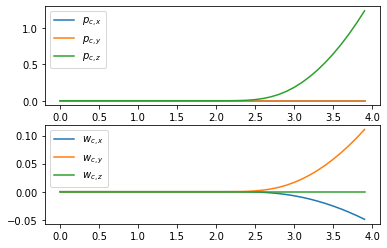

In [122]:
T = 4
s_phi = np.array([1, 1, 1, 1])
p_legs = np.array([[ 0.09,  0.04, 0.18],
                   [ 0.09, -0.04, 0.18],
                   [-0.09,  0.04, 0.18], 
                   [-0.09, -0.04, 0.18]]).T
# splines
q = -m*9.81/4 # test force
get_f = hspline([0, 1, 2, 3, 4],                                          # independent variable
                [[0, 0, 0, 0, 0],[0, 0, 0, 0, 0], [q, q, q, q, q],        # dependent variable
                 [0, 0, 0, 0, 0],[0, 0, 0, 0, 0], [q, q, q, q, q], 
                 [0, 0, 0, 0, 0],[0, 0, 0, 0, 0], [q, q, q, q, q], 
                 [0, 0, 0, 0, 0],[0, 0, 0, 0, 0], [q, q, q, q/2, q/2]], 
                [[0, 0, 0, 0, 0],[0, 0, 0, 0, 0], [0, 0, 0, 0, 0],        # derivative of dependent variable
                 [0, 0, 0, 0, 0],[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], 
                 [0, 0, 0, 0, 0],[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], 
                 [0, 0, 0, 0, 0],[0, 0, 0, 0, 0], [0, 0, 0, 0, 0]],
                 axis=1)


def derivs(state, t):
    '''differential equations for state calculation'''
    f = get_f(t)
    B = get_B(s_phi, state[:3], p_legs)
    state_dot = A@state + B@f + C
    return state_dot


# integrating ODE
t = np.arange(0, T, 0.1)
state = np.zeros(12)
#print((A@state).shape)
#print((B@get_f(0)).shape)
#print(C.shape)
x = integrate.odeint(derivs, state, t)

plt.subplot(211)
plt.plot(t, x[:,0], label="$p_{c,x}$")
plt.plot(t, x[:,1], label="$p_{c,y}$")
plt.plot(t, x[:,2], label="$p_{c,z}$")
plt.legend()
plt.subplot(212)
plt.plot(t, x[:,3], label="$w_{c,x}$")
plt.plot(t, x[:,4], label="$w_{c,y}$")
plt.plot(t, x[:,5], label="$w_{c,z}$")
plt.legend()
plt.show()

Now we can try to fomulate an optimization problem to let the robot jump. One thing that has to be specified beforehand is the duration the robot is in air and has no contact to the ground, which is derived in the following part. We know, that the kinetic energy built up is converted into potential energy:

$$
mgz_\mathrm{max}\,=\,\frac{1}{2}mv_\mathrm{z, esc}
$$

$$
\Leftrightarrow v_\mathrm{z, esc}\,=\,\sqrt{2gz_\mathrm{max}}
$$

where $z_\mathrm{max}$ is the jump hight and $v_\mathrm{z, esc}$ the velocity the robot has after losing contact with the ground.

To calculate the time it takes to reach $z_\mathrm{max}$, we look at the equation of motion in $z$-direction:

$$
z(t_\mathrm{max})\,=\,z_\mathrm{max}\,=\,\frac{1}{2}mgt_\mathrm{max}^2\,+\,v_\mathrm{z, esc}t+z_\mathrm{esc}
$$

$$
\Leftrightarrow t_\mathrm{max}\,=\,-\frac{1}{2}v_\mathrm{z, esc}\,+\,\sqrt{\left(\frac{1}{g}v_\mathrm{z, esc}\right)^2\,-\,\frac{2}{g}\left(z_\mathrm{esc}\,-\,z_\mathrm{max}\right)}
$$

$$
t_\mathrm{flight} = 2t_\mathrm{max}
$$

In [131]:
# jump specific variables (in robot coordinates)
z_max = -0.2
z_esc = -0.1
v_esc = -np.sqrt(2.0*9.81*-z_max)
t_max = -0.5*v_esc + np.sqrt(((1/9.81)*v_esc)**2 + (2/9.81)*(z_esc-z_max))
t_flight = 2*t_max

print(t_flight)

2.4755282491357993


#### Sources
- Winkler, Alexander: Optimization-based motion planning for legged robots